# Testing Q-Values calculation.

In this notebook, we test the Q_Values computation of the Equivariant Quantum Circuit model.

In [1189]:
import numpy as np

from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

# Qiskit imports
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import QuantumCircuit, Parameter

# Qiskit ML imports
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

""" Note: the code is not optimized for GPU
"""
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

## Create Graph Instances
Below we implement a small method to generate random graph instances.

In [1190]:
def get_graph_mat(n=10, size=1):
    """ Throws n nodes uniformly at random on a square, and build a (fully connected) graph.
        Returns the (N, 2) coordinates matrix, and the (N, N) matrix containing pairwise euclidean distances.
    """
    coords = size * np.random.uniform(size=(n,2))
    dist_mat = distance_matrix(coords, coords)
    return coords, dist_mat

def plot_graph(coords, mat):
    """ Utility function to plot the fully connected graph
    """
    n = len(coords)
    
    plt.scatter(coords[:, 0], coords[:, 1], s=[50 for _ in range(n)])
    for i in range(n):
        for j in range(n):
            if j < i:
                plt.plot([coords[i, 0], coords[j, 0]], [coords[i, 1], coords[j, 1]], 'b', alpha=0.7)
                distance = mat[i, j]
                mid_x = (coords[i, 0] + coords[j, 0]) / 2
                mid_y = (coords[i, 1] + coords[j, 1]) / 2
                plt.text(mid_x, mid_y, f'{distance:.2f}', color='red', fontsize=8, ha='center', va='center')

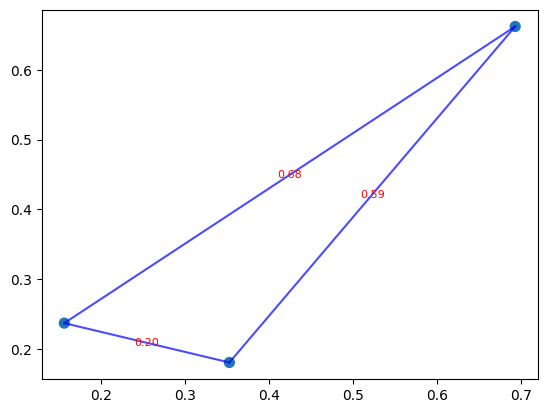

In [1191]:
coords, W_np = get_graph_mat(n=3)
plot_graph(coords, W_np)
plt.show()

## Quantum Circuit

In [1192]:
def graph_encoding_circuit(edges, num_qubits, reps, params, insert_barriers = True) -> QuantumCircuit:
    """
    Defines the graph encoding quantum circuit.
    :param edges: List of tuples of edges.
    :param num_qubits: Number of qubits.
    :param reps: Number of layers.
    :param params: Parameters symbols.
    :param insert_barriers: True if we want barriers in the quantum circuit.
    :return: The Quantum Circuit.
    """
    # Create a quantum circuit
    circuit = QuantumCircuit(num_qubits)

    # Apply Hadamard gates to all qubits
    circuit.h(range(num_qubits))

    for rep in range(reps):
        edge_w = params[rep][-1]

        # Edge encoding
        for edge_i, edge in enumerate(edges):
            circuit.cx(edge[0], edge[1])

            circuit.rz(edge_w[edge_i], edge[1])

            circuit.cx(edge[0], edge[1])

        # This barrier is just to improve visualization, it can be removed
        if insert_barriers: circuit.barrier()

        # Vertex encoding
        for q in range(num_qubits):
            circuit.rx(params[rep][q], q)

    return circuit

## Q - Model

In [1193]:
class EquivariantLayer(nn.Module):
    def __init__(
            self,
            num_input_params : int,
            n_vars : int,
            n_edges : int,
            circuit_depth : int,
            params : list):
        """
        Initialize classical equivariant layer.
        :param num_input_params: Number of input parameters.
        :param n_vars: Number of variables.
        :param n_edges: Number of edges.
        :param circuit_depth: Depth of the circuit (repetitions).
        :param params: List of parameters.
        """
        super(EquivariantLayer, self).__init__()

        # Define weights for the Layer
        self.num_input_params = num_input_params * circuit_depth
        self.num_params = 2 * circuit_depth
        self.circuit_depth = circuit_depth

        param_init = torch.ones(1, self.num_params, dtype=torch.float32)
        self.params = torch.nn.Parameter(param_init)

        self.param_repeats = []
        for layer in range(self.circuit_depth):
            self.param_repeats.append(n_vars)
            self.param_repeats.append(n_edges)

        alphabetical_params = sorted(params)
        self.indices = [params.index(a) for a in alphabetical_params]

    def forward(self, inputs):
        """
        Forward execution of the layer.
        :param inputs: Input data.
        :return: Returns the expectation values.
        """
        repeated_params = self.params.repeat_interleave(torch.tensor(self.param_repeats))

        repeat_inputs = inputs.repeat(self.circuit_depth, 1)

        data_values = repeat_inputs * repeated_params
        output = data_values[:, self.indices]

        return output

In [1194]:
class QModel(nn.Module):
    def __init__(self, n_input_params : int, n_vars : int, num_edges_in_graph : int, n_layers : int,
                 flattened_data_symbols : list, circuit : QuantumCircuit, readout_ops):
        """
        The neural network that will parameterize the function Q.
        
        :param n_input_params: Number of input parameters.
        :param n_vars: Number of variables in the Equivariant Layer.
        :param num_edges_in_graph: Number of edges in the graph.
        :param n_layers: Number of repetitions/layers.
        :param flattened_data_symbols: Flattened data symbols for the Equivariant Layer.
        :param circuit: The Equivariant Quantum Circuit.
        """
        super(QModel, self).__init__()
        self.n_input_params = n_input_params
        self.n_vars = n_vars
        self.num_edges_in_graph = num_edges_in_graph
        self.n_layers = n_layers
        self.flattened_data_symbols = flattened_data_symbols
        
        # Classical encoding layer.
        self.encoding_layer = EquivariantLayer(num_input_params=self.n_input_params, n_vars=self.n_vars, 
                                               n_edges=self.num_edges_in_graph, circuit_depth=self.n_layers, 
                                               params=self.flattened_data_symbols)
        
        # The Equivariant Quantum Circuit for Torch Connector.
        self.circuit = circuit

    def forward(self, input_data, observables) -> torch.Tensor:
        """
        Forward execution of the neural net.
        
        :param input_data: Input data.
        :return: Expectation values for all available nodes.
        """
        encoding_output = self.encoding_layer(input_data)
        qnn = TorchConnector(
            EstimatorQNN(
                circuit=self.circuit,
                input_params=self.circuit.parameters,
                observables=observables
            )
        )
        expectation_values = qnn(encoding_output)

        return expectation_values

In [1195]:
from itertools import combinations

N_NODES = 4
N_LAYERS = 1

fully_connected_qubits = list(combinations(list(range(N_NODES)), 2))

def get_readout_op():
    observables = []
    for edge in fully_connected_qubits:
        observable = SparsePauliOp.from_sparse_list(
                        [("ZZ", [edge[0], edge[1]], 1)],
                        num_qubits=N_NODES
                    )
        observables.append(observable)
    return observables

def generate_eqc_model():
    """
    Generates the EQC model.
    :return: EQC model.
    """
    num_edges_in_graph = len(fully_connected_qubits)
    n_input_params = N_NODES + num_edges_in_graph

    data_symbols = []
    for layer in range(N_LAYERS):
        data = [Parameter(f'layer[{layer}]_v[{qubit}]') for qubit in range(N_NODES)]
        data += [[Parameter(f'layer[{layer}]_e[{ew}]') for ew in range(num_edges_in_graph)]]
        data_symbols.append(data)

    circuit = graph_encoding_circuit(fully_connected_qubits, N_NODES, N_LAYERS, data_symbols)

    flattened_data_symbols = []
    for layer in data_symbols:
        for item in layer:
            if type(item) == list:
                for symbol in item:
                    flattened_data_symbols.append(str(symbol))
            else:
                flattened_data_symbols.append(str(item))

    model = QModel(
        n_input_params=n_input_params, n_vars=N_NODES, 
        num_edges_in_graph=num_edges_in_graph, n_layers=N_LAYERS, 
        flattened_data_symbols=flattened_data_symbols, circuit=circuit,
        readout_ops=get_readout_op()
    )

    return model

The model: 
QModel(
  (encoding_layer): EquivariantLayer()
)
The adjacency matrix: 
[[0.         0.73122981 0.26855357 0.68130193]
 [0.73122981 0.         0.50204171 0.10154257]
 [0.26855357 0.50204171 0.         0.47745734]
 [0.68130193 0.10154257 0.47745734 0.        ]]
List of edge weights: 
[0.7312298085425558, 0.26855357321539824, 0.6813019337820965, 0.5020417148747848, 0.10154256606167858, 0.4774573435912196]
State list: 
[0.0, 0.0, 3.141592653589793, 3.141592653589793, 0.6313795632358417, 0.2623631974989704, 0.5980663912330486, 0.4652796465882788, 0.10119571120773874, 0.4454513979228953]
Tensor state list: 
tensor([[0.0000, 0.0000, 3.1416, 3.1416, 0.6314, 0.2624, 0.5981, 0.4653, 0.1012,
         0.4455]])
Q-Values: 
tensor([[-1.0000e+04, -1.0000e+04, -1.7162e-08, -6.6881e-10]],
       grad_fn=<_TorchNNFunctionBackward>)
Next state: 
tensor(3)


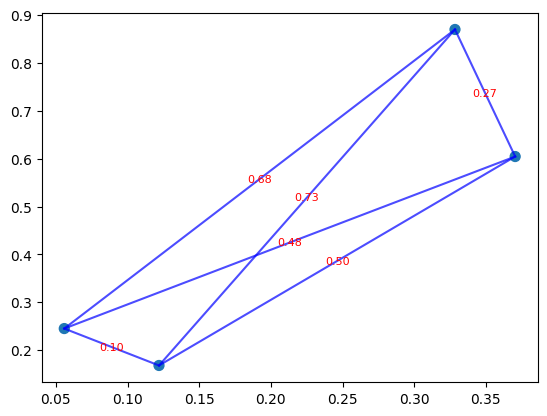

In [1196]:
def graph_to_list(nodes: list, edge_weights: dict, available_nodes: list[int]) -> list[float]:
    """
    Convert a graph into a list.
    :param nodes: list of graph nodes.
    :param fully_connected_edges: list of tuples of edges.
    :param edge_weights: dictionary of edge weights.
    :param available_nodes: list of available nodes.
    :param node_to_qubit_map: dictionary to map nodes and qubits.
    :return: list of values from graph.
    """
    vals = []
    for node in nodes:
        n = int(node in available_nodes)
        vals.append(n * np.pi)

    for w in edge_weights:
        vals.append(np.arctan(w))

    return vals

def get_mask(nodes, weight_mat, available_nodes, partial_tour):
    mask = []
    for n in nodes:
        if n not in available_nodes:
            mask.append(0)
        elif n in available_nodes:
            mask.append(weight_mat[partial_tour[-1], n])
    return mask

def get_observables(partial_tour, available_nodes, weight_mat, nodes):
    observables = []
    last_edge = () if len(partial_tour) == 0 else partial_tour[-1]
    last_node = 0 if len(last_edge) == 0 else last_edge[1]
    
    for node in nodes:
        if node in available_nodes:
            observable = SparsePauliOp.from_sparse_list(
                [("ZZ", [last_node, node], weight_mat[last_node, node])],
                num_qubits=N_NODES
            )
            observables.append(observable)
        else:
            observable = SparsePauliOp.from_sparse_list(
                [("I", [0], -10000)],
                num_qubits=N_NODES
            )
            observables.append(observable)   
    return observables

# Generate model
model = generate_eqc_model()
print("The model: ")
print(model)
print("===================")

# Generate a TSP graph
coords, weight_mat = get_graph_mat(n=N_NODES)
plot_graph(coords, weight_mat)
nodes = range(0, N_NODES)
print("The adjacency matrix: ")
print(weight_mat)
print("===================")

# Initial node and available nodes
initial_node = 0
available_nodes = [2, 3]
partial_tour = [(0, 1)]

# Get list of available edge weights
edge_weights = []
for q in fully_connected_qubits:
    edge_weights.append(weight_mat[q[0], q[1]])
print("List of edge weights: ")
print(edge_weights)
print("===================")

# Convert graph into a state list
state_list = graph_to_list(
    nodes=nodes, 
    edge_weights=edge_weights,
    available_nodes=available_nodes
)
print("State list: ")
print(state_list)
print("===================")

# Convert state list into a tensor:
state_tsr = torch.tensor(state_list, dtype=torch.float32).unsqueeze(0)
print("Tensor state list: ")
print(state_tsr)
print("===================")

# Get Q-Values:
expectations = model(state_tsr, get_observables(
    partial_tour=partial_tour,
    available_nodes=available_nodes,
    weight_mat=weight_mat,
    nodes=nodes
))
print("Q-Values: ")
print(expectations)
print("===================")

# Get next action:
next_state = torch.argmax(expectations)
print("Next state: ")
print(next_state)
print("===================")